In [1]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
from datetime import datetime
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
import requests
import tensorflow.keras.backend as K
from sklearn import decomposition

#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

print(tf.__version__)

2.0.0


In [2]:
sns.set_style('ticks')

In [3]:
champfile=os.path.join('lol_data','version9.10.1_champion.json')
with open(champfile,'r') as fin:
    champdata=json.load(fin)
champ_vocab=[]
for name,data in champdata['data'].items():
    champ_vocab.append(data['key'])
champ_vocab = [int(i) for i in champ_vocab]
print(len(champ_vocab))

144


# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline

In [4]:
def _parse_function(example_proto):
    """Extracts features and labels.
  
    Args:
        example_proto: tf.Example protocol (unsure what this is)    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8-bit ints for heroes
        "label": tf.io.FixedLenFeature(1, tf.int64)
                }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    
    labels = parsed_features['label']
    
    #return radiant_heroes,dire_heroes, labels
    return {'radiant_heroes':radiant_heroes,'dire_heroes': dire_heroes}, labels

In [5]:
def _parse_function_one_hero_array(example_proto):
    """Extracts features and labels.
  
    Args:
        example_proto: tf.Example protocol (unsure what this is)    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature(5, dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature(5, dtype=tf.int64), #array of five 8-bit ints for heroes
        "skill_level": tf.io.FixedLenFeature(2, dtype=tf.int64),
        "targets": tf.io.FixedLenFeature(1, tf.int64)
                }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    skill= parsed_features['skill_level']
    target = parsed_features['targets']
    
    return {'heroes':[radiant_heroes,dire_heroes],'skill_level':skill},\
            target

In [6]:
def _parse_function_dual(example_proto):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8-bit ints for heroes
        "skill_level": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "radiant_win" :tf.io.FixedLenFeature([1], dtype=tf.int64),
        "gold_diff": tf.io.FixedLenFeature([1], dtype=tf.float32)
                }
  
    parsed_features = tf.io.parse_single_example(example_proto, features)
  
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    skill = parsed_features['skill_level']
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']

    #return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
    #       {'radiant_win':radiant_win, 'gold_diff':gold_diff}
    return {'heroes':[radiant_heroes,dire_heroes],'skill_level':skill},\
                {'gold_diff': gold_diff, 'radiant_win':radiant_win}

In [7]:
def _parse_function_triple(example_proto):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A 2D tensors representing the heroes
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8-bit ints for heroes
        "skill_level": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "radiant_win" :tf.io.FixedLenFeature([1], dtype=tf.int64),
        "gold_diff": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "total_gold": tf.io.FixedLenFeature([1], dtype=tf.float32)
                }
  
    parsed_features = tf.io.parse_single_example(example_proto, features)
  
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    skill = parsed_features['skill_level']
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']
    total_gold = parsed_features['total_gold']

    #return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
    #       {'radiant_win':radiant_win, 'gold_diff':gold_diff}
    return {'heroes':[radiant_heroes,dire_heroes],
                 'skill_level':skill},\
            {'gold_diff': gold_diff,
                 'total_gold':total_gold,
                 'radiant_win':radiant_win}

In [8]:
def _parse_function_penta(example_proto):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A 2D tensors representing the heroes
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8-bit ints for heroes
        "skill_level": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "radiant_win" :tf.io.FixedLenFeature([1], dtype=tf.int64),
        "gold_diff": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "total_gold": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "tower_damage_diff": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "total_tower_damage": tf.io.FixedLenFeature([1], dtype=tf.float32)
                }
  
    parsed_features = tf.io.parse_single_example(example_proto, features)
  
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    skill = parsed_features['skill_level']
        
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']
    total_gold = parsed_features['total_gold']
    towdam_diff = parsed_features['tower_damage_diff']
    total_towdam = parsed_features['total_tower_damage']

    #return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
    #       {'radiant_win':radiant_win, 'gold_diff':gold_diff}
    return {'heroes':[radiant_heroes,dire_heroes],
                 'skill_level':skill},\
            {'gold_diff': gold_diff,
                 'total_gold':total_gold,
                 'tower_damage_diff':towdam_diff,
                 'total_tower_damage': total_towdam,
                 'radiant_win':radiant_win}

#### Check the parse function worked

In [9]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('LOL_data',
                                          'mix_tier',
                                          'lol_training_data',
                                          'blue_win_dota2_compat_lol_training_data.tfrecords'),
                             compression_type="GZIP")
# Map features and labels with the parse function.
ds = ds.map(_parse_function_one_hero_array)

In [10]:
ds = ds.shuffle(10000)
print(next(iter(ds)))

({'heroes': <tf.Tensor: id=40, shape=(2, 5), dtype=int64, numpy=
array([[ 86, 132, 129,   2,  41],
       [ 66, 123, 139,  24,  33]])>, 'skill_level': <tf.Tensor: id=41, shape=(2,), dtype=int64, numpy=array([0, 1])>}, <tf.Tensor: id=42, shape=(1,), dtype=int64, numpy=array([1])>)


## Model Functions

In [11]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn_multi(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type="",target_num=2):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    
    if target_num==2:
        ds = ds.map(_parse_function_dual)
    elif target_num==3:
        ds = ds.map(_parse_function_triple)
    elif target_num==5:
        ds = ds.map(_parse_function_penta)
    elif target_num==1:
        ds = ds.map(_parse_function_one_hero_array)
    else:
        raise KeyError
    
    if shuffle:
        ds = ds.shuffle(10000)
    
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    #gold_ds = ds.map(_parse_function_multi_to_gold)
    #win_ds = ds.map(_parse_function_multi_to_win)
    
    # Return the dataset.
    #return gold_ds, win_ds
    return ds

In [12]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn_single_example(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
   # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function_nodict)

    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    
    # Return the dataset.
    return ds

In [13]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    # Return the dataset.
    return ds

## Define and train the linear model

### various iterations of linear models

In [14]:
#define the linear model with no feature columns
def train_linear_model_no_feature_columns(optimizer, 
                                          vocab_len, 
                                          embedding_dims,
                                          batch_size,
                                          epochs,
                                          training_path,
                                          validation_path,
                                          compression_type='',
                                          temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        history: A `tf.keras.history` object that has loss and other metrics
    '''

    all_heroes = tf.keras.Input(shape=(2,5,),name='heroes')
    skill = tf.keras.Input(shape=(2,),name='skill_level')
    
    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    x = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single embedded vector for each team
    x = tf.keras.layers.Dense(1, activation='linear')(x)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)

    #concat skill input with output of embedding input
    x = tf.keras.layers.concatenate([x, skill])
    
    #Adds output layer with sigmoid activation for prediction
    win_predict = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[all_heroes,skill],
                           outputs=win_predict,name="linear_classifier")
    
    model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

    #get embedding weights for returning and saving
    embedding_weights = model.layers[1].get_weights()[0]
    
    #get datasets from tfrecords and according to input_fn
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=1)

    validation_ds= _input_fn_multi(validation_path,
                                   batch_size=batch_size,
                                   compression_type=compression_type,
                                   target_num=1)

    #allow logging in temp directory or directory to be included in git
    #  useful if tuning hyperparams or testing
    if temp_log_flag==True:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("lol_%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    steps_per_epoch=50
    history = model.fit(train_ds, 
                        epochs = epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=steps_per_epoch,
                        verbose=0,
                        validation_data=validation_ds,
                        callbacks=[tensorboard_callback]
                       )
    
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')
    
    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item()
    training_params = dict({'model_type':'single_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'batch_size':batch_size,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)
    
    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)
    
    fig,ax = plt.subplots(1,1,figsize=(1.6*3,3))
    plt.plot(history.history['accuracy'])
    plt.xlabel('epochs (50 steps per)')
    plt.ylabel('accuracy')
    plt.show()
    
    return history

In [29]:
#define the linear model with feature columns and dual targets
def train_linear_model_dual(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='heroes')
    skill = tf.keras.Input(shape=(2,),name='skill_level')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,skill])
    
    #Adds output layer with softmax activation for prediction
    aux_pred = tf.keras.layers.Dense(1,activation='linear',
                                      name='gold_diff')(x)
    
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)

    win_inputs = tf.keras.layers.concatenate([x,aux_pred,skill])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    dual_model = tf.keras.Model(inputs=[all_heroes,skill],
                                outputs=[aux_pred,win_pred])
    dual_model.compile(optimizer=optimizer,
                      loss = ['mse', 'binary_crossentropy'],
                      loss_weights = [aux_weight, 1],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = dual_model.layers[1].get_weights()[0]

    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=2)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=2)

    #allow logging in temp directory or directory to be included in git
    #  useful if tuning hyperparams or testing
    if temp_log_flag==True:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("lol_%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))

    #add tensorboard callback for model inspection/watching training/embedding 
    #  exploration in an easy way.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    
    #fit model and keep history object for returning
    steps_per_epoch=50
    history = dual_model.fit(train_ds, 
                             epochs = epochs,
                             steps_per_epoch=steps_per_epoch,
                             validation_steps=steps_per_epoch,
                             verbose=2,
                             validation_data=val_ds,
                             callbacks=[tensorboard_callback]
                            )
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    dual_model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')
    
    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item() #numpy can't be serialized
    training_params = dict({'model_type':'dual_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'batch_size':batch_size,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)
    
    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)
    
    fig, (ax1,ax2)= plt.subplots(1,2,sharey=False,figsize=(5*1.6,5))
    ax2.plot(history.history['gold_diff_loss'])
    ax1.plot(history.history['radiant_win_loss'])
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('win_loss')
    ax2.set_ylabel('gold_loss')
    plt.show()

    fig,ax = plt.subplots(1,1,figsize=(1.6*3,3))
    plt.plot(history.history['radiant_win_accuracy'])
    plt.xlabel('epochs (50 steps per)')
    plt.ylabel('accuracy')
    plt.show()

    #return gold_history,win_history
    return history

In [27]:
#define the linear model with feature columns and three targets
def train_linear_model_triple(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='heroes')
    skill = tf.keras.Input(shape=(2,),name='skill_level')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)

    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,skill])
    #Adds output layer with softmax activation for prediction
    gold_diff = tf.keras.layers.Dense(1,activation='linear',
                                      name='gold_diff')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,skill,gold_diff])
    total_gold = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_gold')(x)
    
    #do similar fit and processing layers starting for radiant_win,
    #  and use gold_diff and total_gold to help predict win
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    win_inputs = tf.keras.layers.concatenate([x,skill,
                                              gold_diff,total_gold])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    
    #create and compile model with three outputs
    #  with auxiliary outputs deemphasized by aux_weight
    triple_model = tf.keras.Model(inputs=[all_heroes,skill], outputs=[gold_diff,
                                                            total_gold,
                                                            win_pred])
    triple_model.compile(optimizer=optimizer,
                      loss = ['mse','mse', 'binary_crossentropy'],
                      loss_weights = [aux_weight,aux_weight, 1/0.7],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = triple_model.layers[1].get_weights()[0]
    
    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=3)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=3)
    
    #log training data in temp folder unless the flag is false
    if temp_log_flag:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("lol_%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    #add tensorboard callback for model inspection/watching training/embedding 
    #  exploration in an easy way.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                          write_images=True,
                                                          embeddings_freq=1)
    #fit model
    steps_per_epoch = 50
    history = triple_model.fit(train_ds, 
                               epochs = epochs,
                               steps_per_epoch=steps_per_epoch,
                               validation_steps=steps_per_epoch,
                               verbose=0,
                               validation_data=val_ds,
                               callbacks=[tensorboard_callback]
                               )
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    triple_model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')

    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item()
    training_params = dict({'model_type':'triple_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'batch_size': batch_size,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)

    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)

    #plot results with loss side by side and win accuracy alone
    fig, [ax1,ax2,ax3]= plt.subplots(1,3,sharey=False,figsize=(5*1.6,5))
    ax3.plot(history.history['total_gold_loss'])
    ax2.plot(history.history['gold_diff_loss'])
    ax1.plot(history.history['radiant_win_loss'])
    ax3.set_xlabel('epochs (50 steps per)')
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('radiant_win loss')
    ax2.set_ylabel('gold_diff loss')
    ax3.set_ylabel('total_gold loss')
    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1,1,figsize=(3*1.6,3))
    plt.plot(history.history['radiant_win_accuracy'])
    plt.xlabel('epochs (50 steps per)')
    plt.ylabel('accuracy')
    plt.show()

    #return embedding weights and history for model.fit
    return history

In [33]:
#define the linear model with feature columns and three targets
def train_linear_model_penta(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='heroes')
    skill = tf.keras.Input(shape=(2,),name='skill_level')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,skill])

    #Adds output layer with softmax activation for prediction
    total_gold = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_gold')(x)

    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,skill,total_gold])
    gold_diff = tf.keras.layers.Dense(1,activation='linear',
                                      name='gold_diff')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,skill,gold_diff,total_gold])
    total_towdam = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_tower_damage')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,skill,gold_diff,
                                     total_gold,total_towdam])
    towdam_diff= tf.keras.layers.Dense(1,activation='linear',
                                        name = 'tower_damage_diff')(x)
    
    #do similar fit and processing layers starting for radiant_win,
    #  and use gold_diff and total_gold to help predict win
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    win_inputs = tf.keras.layers.concatenate([x,skill,
                                              gold_diff,total_gold,
                                              towdam_diff,total_towdam])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    
    #create and compile model with three outputs
    #  with auxiliary outputs deemphasized by aux_weight
    penta_model = tf.keras.Model(inputs=[all_heroes,skill], outputs=[gold_diff,
                                                            total_gold,
                                                            towdam_diff,
                                                            total_towdam,
                                                            win_pred])
    penta_model.compile(optimizer=optimizer,
                      loss = ['mse','mse',
                              'mse','mse',
                              'binary_crossentropy'],
                      loss_weights = [aux_weight,aux_weight,
                                      aux_weight,aux_weight,
                                      1/0.7],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = penta_model.layers[1].get_weights()[0]
    
    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=5)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=5)
    
    #log training data in temp folder unless the flag is false
    if temp_log_flag:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("lol_%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    #add tensorboard callback for model inspection/watching training/embedding 
    #  exploration in an easy way.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                          write_images=True,
                                                          embeddings_freq=1)
    #fit model
    steps_per_epoch = 50
    history = penta_model.fit(train_ds, 
                               epochs = epochs,
                               steps_per_epoch=steps_per_epoch,
                               validation_steps=steps_per_epoch,
                               verbose=0,
                               validation_data=val_ds,
                               callbacks=[tensorboard_callback]
                               )
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    penta_model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')

    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item() #numpy can't be serialized
    training_params = dict({'model_type':'penta_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'batch_size': batch_size,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)

    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)

    #plot results with loss side by side and win accuracy alone
    fig, ax= plt.subplots(2,2,sharey=True,figsize=(5*1.6,5),sharex=True)
    ax[0,0].plot(history.history['total_gold_loss'])
    ax[0,1].plot(history.history['gold_diff_loss'])
    ax[1,0].plot(history.history['total_tower_damage_loss'])
    ax[1,1].plot(history.history['tower_damage_diff_loss'])
    #ax[0,0].set_xticks([])
    #ax[0,1].set_xticks([])
    #ax[0,1].set_yticks([])
    #ax[1,1].set_yticks([])
    ax[0,0].set_ylabel('total and diff gold loss')
    #ax[1,0].set_ylabel('gold_diff loss')
    ax[1,0].set_ylabel('total and diff tower_damage loss')
    #ax[1,1].set_ylabel('tower_damage_diff loss')
    ax[1,0].set_xlabel('epochs(50 steps per)')
    ax[1,1].set_xlabel('epochs(50 steps per)')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(1.6*3,6),sharex=True)
    ax1.plot(history.history['radiant_win_loss'])
    ax2.plot(history.history['radiant_win_accuracy'])
    #ax1.set_xticks([])
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('radiant_win_loss')
    ax2.set_ylabel('accuracy')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    #return embedding weights and history for model.fit
    return history

### train no feature column win model

In [20]:
training_file_novocab = os.path.join('LOL_data',
                             'mix_tier',
                             'lol_training_data',
                             'blue_win_dota2_compat_lol_training_data.tfrecords')
validation_file_novocab = os.path.join('LOL_data',
                             'mix_tier',
                             'lol_validation_data',
                             'blue_win_dota2_compat_lol_validation_data.tfrecords')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../../../tmp_log_dir/lol_20191108-193958/saved_model/assets


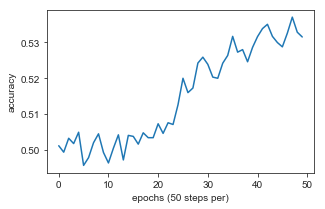

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_no_feature_columns(
            optimizer,
            vocab_len=len(champ_vocab),
            embedding_dims=3,
            batch_size=500, 
            epochs=50, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/lol_20191108-194327/saved_model/assets


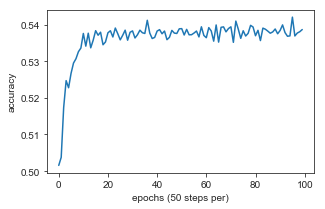

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_linear_model_no_feature_columns(
            optimizer,
            vocab_len=len(champ_vocab),
            embedding_dims=3,
            batch_size=1000, 
            epochs=100, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/lol_20191108-195530/saved_model/assets


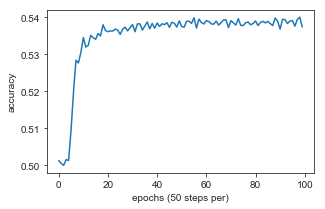

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
history = train_linear_model_no_feature_columns(
            optimizer,
            vocab_len=len(champ_vocab),
            embedding_dims=3,
            batch_size=2000, 
            epochs=100, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

### train dual gold_diff win model

In [25]:
training_file_dual_novocab = os.path.join('LOL_data',
                             'mix_tier',
                             'lol_training_data',
                             'dual_gold_win_dota2_compat_lol_training_data.tfrecords')
validation_file_dual_novocab = os.path.join('LOL_data',
                             'mix_tier',
                             'lol_validation_data',
                             'dual_gold_win_dota2_compat_lol_validation_data.tfrecords')

Train for 50 steps, validate for 50 steps
Epoch 1/20
50/50 - 6s - loss: 0.8201 - gold_diff_loss: 1.0681 - radiant_win_loss: 0.7133 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.4953 - val_loss: 0.8024 - val_gold_diff_loss: 1.0170 - val_radiant_win_loss: 0.7007 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.4968
Epoch 2/20
50/50 - 4s - loss: 0.7992 - gold_diff_loss: 1.0150 - radiant_win_loss: 0.6977 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5034 - val_loss: 0.7973 - val_gold_diff_loss: 1.0076 - val_radiant_win_loss: 0.6966 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.4997
Epoch 3/20
50/50 - 5s - loss: 0.7970 - gold_diff_loss: 1.0060 - radiant_win_loss: 0.6964 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.4981 - val_loss: 0.7953 - val_gold_diff_loss: 1.0013 - val_radiant_win_loss: 0.6952 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.4976
Epoch 4/20
50/50 - 4s - loss: 0.7954 - gold_di

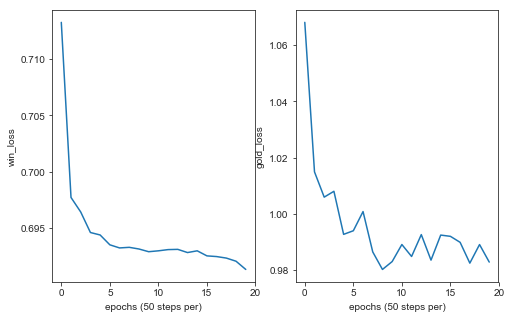

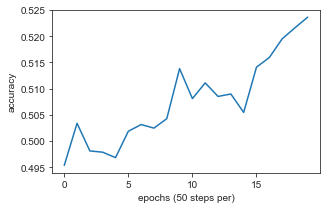

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_dual(
            optimizer,
            vocab_len=len(champ_vocab),
            embedding_dims=3,
            batch_size=500,
            epochs=20, 
            aux_weight=0.1,
            training_path=training_file_dual_novocab, 
            validation_path=validation_file_dual_novocab,
            compression_type='GZIP')

Train for 50 steps, validate for 50 steps
Epoch 1/40
50/50 - 7s - loss: 0.8721 - gold_diff_loss: 1.4576 - radiant_win_loss: 0.7263 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.4962 - val_loss: 0.8267 - val_gold_diff_loss: 1.1879 - val_radiant_win_loss: 0.7079 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5020
Epoch 2/40
50/50 - 5s - loss: 0.8140 - gold_diff_loss: 1.0853 - radiant_win_loss: 0.7055 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5010 - val_loss: 0.8046 - val_gold_diff_loss: 1.0332 - val_radiant_win_loss: 0.7013 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5049
Epoch 3/40
50/50 - 4s - loss: 0.8021 - gold_diff_loss: 1.0306 - radiant_win_loss: 0.6991 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5047 - val_loss: 0.7990 - val_gold_diff_loss: 1.0101 - val_radiant_win_loss: 0.6980 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5033
Epoch 4/40
50/50 - 5s - loss: 0.8004 - gold_di

Epoch 28/40
50/50 - 5s - loss: 0.7908 - gold_diff_loss: 0.9953 - radiant_win_loss: 0.6913 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5270 - val_loss: 0.7909 - val_gold_diff_loss: 0.9880 - val_radiant_win_loss: 0.6921 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5201
Epoch 29/40
50/50 - 5s - loss: 0.7920 - gold_diff_loss: 1.0014 - radiant_win_loss: 0.6919 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5200 - val_loss: 0.7913 - val_gold_diff_loss: 0.9922 - val_radiant_win_loss: 0.6921 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5208
Epoch 30/40
50/50 - 4s - loss: 0.7906 - gold_diff_loss: 0.9921 - radiant_win_loss: 0.6914 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5243 - val_loss: 0.7908 - val_gold_diff_loss: 0.9903 - val_radiant_win_loss: 0.6917 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5237
Epoch 31/40
50/50 - 5s - loss: 0.7918 - gold_diff_loss: 0.9985 - radiant_win_loss: 0.

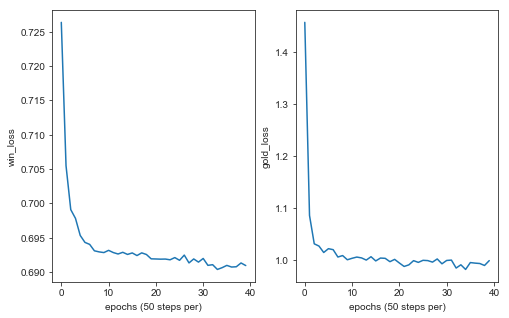

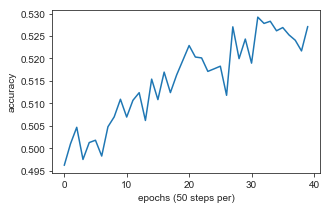

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_dual(
            optimizer,
            vocab_len=len(champ_vocab),
            embedding_dims=3,
            batch_size=500,
            epochs=40, 
            aux_weight=0.1,
            training_path=training_file_dual_novocab, 
            validation_path=validation_file_dual_novocab,
            compression_type='GZIP')

Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 - 17s - loss: 0.9171 - gold_diff_loss: 1.5943 - radiant_win_loss: 0.7577 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.4995 - val_loss: 0.8725 - val_gold_diff_loss: 1.4126 - val_radiant_win_loss: 0.7313 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.4994
Epoch 2/100
50/50 - 15s - loss: 0.8401 - gold_diff_loss: 1.2570 - radiant_win_loss: 0.7144 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.4991 - val_loss: 0.8127 - val_gold_diff_loss: 1.1197 - val_radiant_win_loss: 0.7007 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.4991
Epoch 3/100
50/50 - 15s - loss: 0.8025 - gold_diff_loss: 1.0654 - radiant_win_loss: 0.6960 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5056 - val_loss: 0.7976 - val_gold_diff_loss: 1.0368 - val_radiant_win_loss: 0.6939 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5125
Epoch 4/100
50/50 - 15s - loss: 0.7954 -

Epoch 28/100
50/50 - 15s - loss: 0.7868 - gold_diff_loss: 0.9824 - radiant_win_loss: 0.6885 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5384 - val_loss: 0.7875 - val_gold_diff_loss: 0.9855 - val_radiant_win_loss: 0.6889 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5373
Epoch 29/100
50/50 - 16s - loss: 0.7878 - gold_diff_loss: 0.9873 - radiant_win_loss: 0.6891 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5367 - val_loss: 0.7876 - val_gold_diff_loss: 0.9841 - val_radiant_win_loss: 0.6892 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5353
Epoch 30/100
50/50 - 15s - loss: 0.7874 - gold_diff_loss: 0.9851 - radiant_win_loss: 0.6889 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5374 - val_loss: 0.7876 - val_gold_diff_loss: 0.9848 - val_radiant_win_loss: 0.6891 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5363
Epoch 31/100
50/50 - 14s - loss: 0.7865 - gold_diff_loss: 0.9794 - radiant_win_

Epoch 55/100
50/50 - 15s - loss: 0.7870 - gold_diff_loss: 0.9823 - radiant_win_loss: 0.6888 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5398 - val_loss: 0.7874 - val_gold_diff_loss: 0.9820 - val_radiant_win_loss: 0.6892 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5355
Epoch 56/100
50/50 - 15s - loss: 0.7866 - gold_diff_loss: 0.9794 - radiant_win_loss: 0.6886 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5372 - val_loss: 0.7870 - val_gold_diff_loss: 0.9824 - val_radiant_win_loss: 0.6888 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5371
Epoch 57/100
50/50 - 15s - loss: 0.7871 - gold_diff_loss: 0.9845 - radiant_win_loss: 0.6887 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5384 - val_loss: 0.7874 - val_gold_diff_loss: 0.9836 - val_radiant_win_loss: 0.6891 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5369
Epoch 58/100
50/50 - 15s - loss: 0.7869 - gold_diff_loss: 0.9823 - radiant_win_

Epoch 82/100
50/50 - 15s - loss: 0.7870 - gold_diff_loss: 0.9845 - radiant_win_loss: 0.6886 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5393 - val_loss: 0.7870 - val_gold_diff_loss: 0.9812 - val_radiant_win_loss: 0.6889 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5371
Epoch 83/100
50/50 - 15s - loss: 0.7868 - gold_diff_loss: 0.9805 - radiant_win_loss: 0.6887 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5383 - val_loss: 0.7873 - val_gold_diff_loss: 0.9817 - val_radiant_win_loss: 0.6891 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5365
Epoch 84/100
50/50 - 15s - loss: 0.7862 - gold_diff_loss: 0.9791 - radiant_win_loss: 0.6883 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5392 - val_loss: 0.7870 - val_gold_diff_loss: 0.9806 - val_radiant_win_loss: 0.6890 - val_gold_diff_accuracy: 0.0000e+00 - val_radiant_win_accuracy: 0.5367
Epoch 85/100
50/50 - 15s - loss: 0.7871 - gold_diff_loss: 0.9840 - radiant_win_

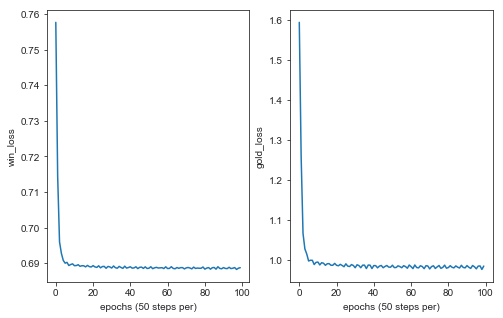

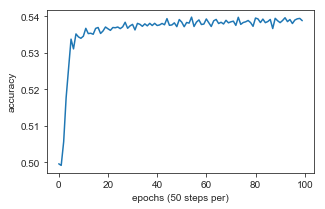

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_dual(
            optimizer,
            vocab_len=len(champ_vocab),
            embedding_dims=3,
            batch_size=2000,
            epochs=100, 
            aux_weight=0.1,
            training_path=training_file_dual_novocab, 
            validation_path=validation_file_dual_novocab,
            compression_type='GZIP')

### train triple gold_diff, total_gold, radiant_win model

In [29]:
training_file_triple_novocab = os.path.join('LOL_data',
                             'mix_tier',
                             'lol_training_data',
                             'triple_gold_win_dota2_compat_lol_training_data.tfrecords')
validation_file_triple_novocab = os.path.join('LOL_data',
                             'mix_tier',
                             'lol_validation_data',
                             'triple_gold_win_dota2_compat_lol_validation_data.tfrecords')

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191108-231357/saved_model/assets


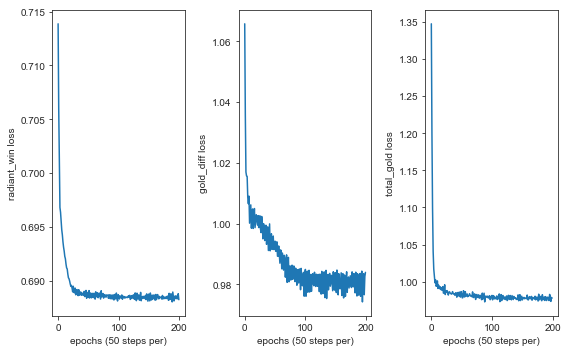

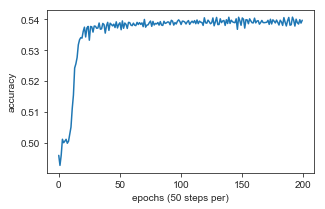

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_triple(
            optimizer,
            vocab_len=len(champ_vocab),
            embedding_dims=3,
            batch_size=2000,
            epochs=200, 
            aux_weight=0.2,
            training_path=training_file_triple_novocab, 
            validation_path=validation_file_triple_novocab,
            compression_type='GZIP')

### train penta linear model (2xgold 2xtower and win)

In [21]:
training_file_penta_novocab = os.path.join('LOL_data',
                             'mix_tier',
                             'lol_training_data',
                             'penta_gold_win_dota2_compat_lol_training_data.tfrecords')
validation_file_penta_novocab = os.path.join('LOL_data',
                             'mix_tier',
                             'lol_validation_data',
                             'penta_gold_win_dota2_compat_lol_validation_data.tfrecords')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191109-094530/saved_model/assets


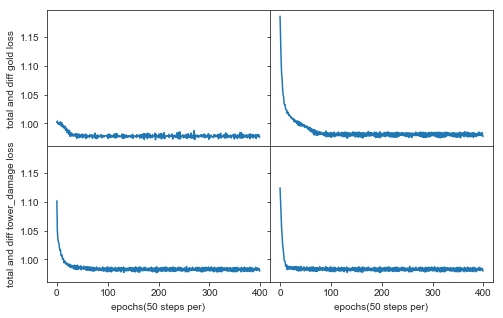

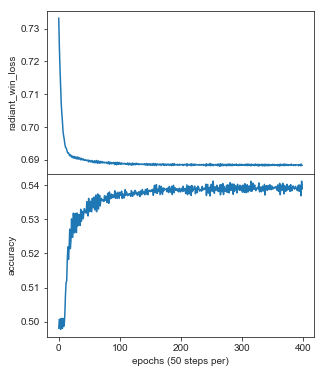

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta(
            optimizer,
            vocab_len=len(champ_vocab),
            embedding_dims=5,
            batch_size=2000,
            epochs=400, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/lol_20191109-123426/saved_model/assets


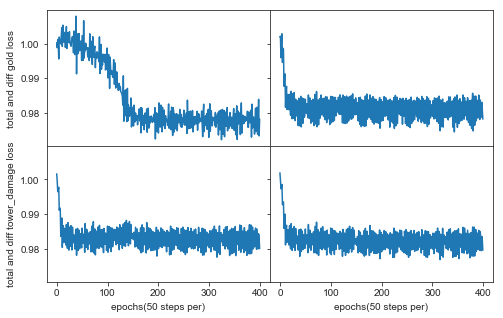

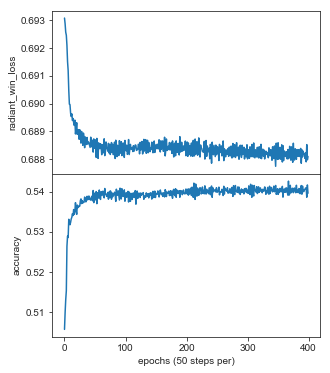

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta(
            optimizer,
            vocab_len=len(champ_vocab),
            embedding_dims=5,
            batch_size=2000,
            epochs=400, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/lol_20191109-215914/saved_model/assets


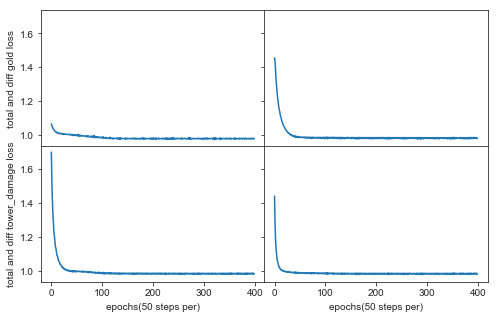

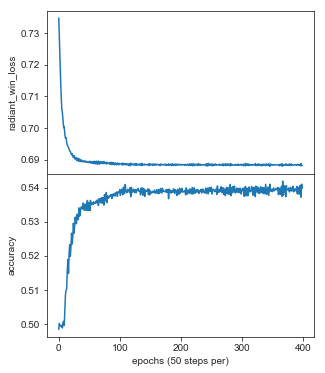

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta(
            optimizer,
            vocab_len=len(champ_vocab),
            embedding_dims=5,
            batch_size=2000,
            epochs=400, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/lol_20191110-091800/saved_model/assets


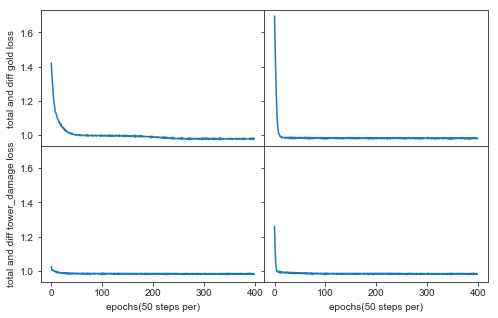

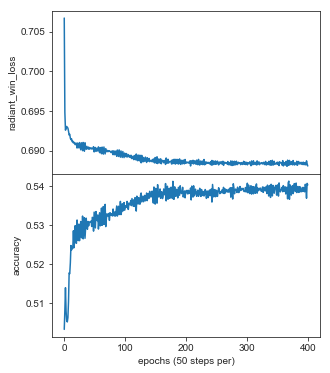

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta(
            optimizer,
            vocab_len=len(champ_vocab),
            embedding_dims=5,
            batch_size=2000,
            epochs=400, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_linear_model_penta_auxconnect(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=10000,
            epochs=20, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_linear_model_penta_auxconnect(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=10000,
            epochs=100, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
history = train_linear_model_penta_auxconnect(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=5000,
            epochs=100, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

### train radiant_win model with feature columns
not needed and possibly a worse architecture (hard to inspect it though)

In [97]:
training_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_windota2_training_data.tfrecords')
validation_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_windota2_validation_data.tfrecords')
categorical_columns = [tf.feature_column.categorical_column_with_vocabulary_list(
                                                'radiant_heroes',
                                                hero_vocab),
                               tf.feature_column.categorical_column_with_vocabulary_list(
                                                'dire_heroes',
                                                hero_vocab)]
indicator_columns = [tf.feature_column.indicator_column(
                                        categorical_columns[0]),
                            tf.feature_column.indicator_column(
                                        categorical_columns[1])]
embedding_dim = 3
embedding_columns = [tf.feature_column.embedding_column(
                                categorical_columns[0],
                                embedding_dim),
                    tf.feature_column.embedding_column(
                                categorical_columns[1],
                                embedding_dim)]

In [98]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_model(optimizer,
            indicator_columns,
            batch_size=500, 
            epochs=5, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

NameError: name 'vocab_len' is not defined

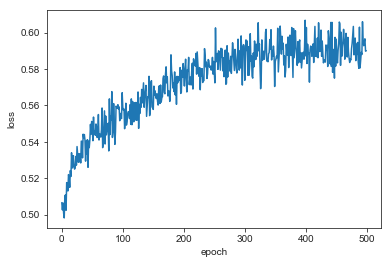

In [82]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_model(optimizer,
            embedding_columns,
            batch_size=500, 
            epochs=500, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

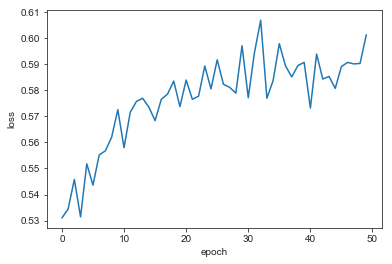

In [85]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_model(optimizer,
            embedding_columns,
            batch_size=500, 
            epochs=50, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

In [51]:
%load_ext tensorboard

In [52]:
log = os.path.join('..','..','..','tmp_log_dir')
%tensorboard --logdir '../../../tmp_log_dir' --reload_multifile=true

Reusing TensorBoard on port 6014 (pid 9324), started 21:09:55 ago. (Use '!kill 9324' to kill it.)